[12 权重衰退【动手学深度学习v2】](https://www.bilibili.com/video/BV1UK4y1o7dy?spm_id_from=333.999.0.0)


- 权重衰减就是我们常说的L2正则化
- 为什么见附录

$$W_{t+1} = (1-\eta\lambda)W_t-\eta\frac{\partial \iota(W_t,b)}{\partial W_t}$$

- $\eta\lambda$为学习率*L2正则项超参数，务必保证该值小于1

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

$$y = 0.05 +\displaystyle\sum\limits_{i=1}^d 0.01x_i+\epsilon\:where\:\epsilon\:\longrightarrow\:N(0,0.01^2)$$

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
# synthetic_data合成数据
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [3]:
# 初始化模型参数
def init_params():
    w = torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b = torch.zeros(1,requires_grad=True)
    return [w,b]

In [4]:
# 定义L2惩罚函数
def l2_penalty(w):
    return torch.sum(w.pow(2))/2
    # return torch.sum(w**2)/2

In [5]:
def train(lambd):
    w, b = init_params()
    # 生成一个线性回归函数，损失函数采用平方损失
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    # 此部分还是绘画模块
    animator = d2l.Animator(xlabel='epochs',
                            ylabel='loss',
                            yscale='log',
                            figsize=(6,3),
                            xlim=[5, num_epochs],
                            legend=['train', 'test'])
    # 依旧是迭代循环
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                # 增加了L2范数惩罚项，⼴播机制使l2_penalty(w)成为⼀个⻓度为`batch_size`的向量。
                l = loss(net(X), y) + lambd * l2_penalty(w)
                l.sum().backward()
                d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    # norm是求2范数，item是求数值
    print('w的L2范数是：', torch.norm(w).item())


w的L2范数是： 13.665496826171875


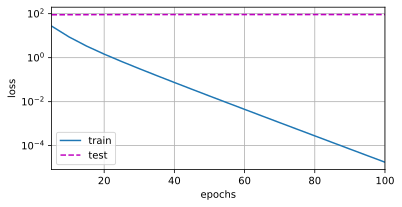

In [6]:
train(0)
# 可以看出有用训练数据较少，出现了严重的过拟合，test函数的loss基本没有下降

w的L2范数是： 0.37754058837890625


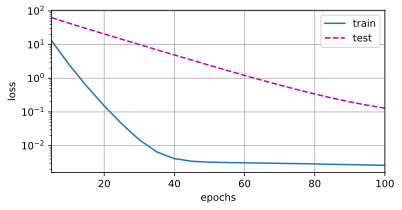

In [7]:
train(3)
# 引入L2范数后，test的loss出现了同步下降,有效避免了过拟合

In [8]:
# 简洁实现
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减。
    # 'weight_decay'就是我们需要的L2范数超参数
    trainer = torch.optim.SGD([{"params":net[0].weight,'weight_decay': wd},{"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 12.617652893066406


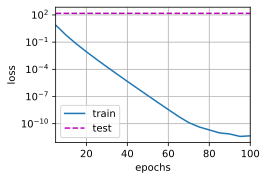

In [9]:
train_concise(0)

w的L2范数： 0.6613436341285706


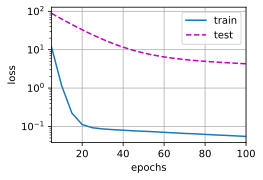

In [10]:
train_concise(3)